In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-gs/build/python')
sys.path.append("..")

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool
mi.set_variant('cuda_ad_rgb')

jit_find_library(): Unable to load "/usr/lib/llvm-15/lib/libLLVM.so": /home/jonathan/miniconda3/envs/volprim/lib/python3.11/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/llvm-15/lib/libLLVM.so)!


In [2]:
import volprim
from volprim.integrators.common import *

In [3]:
# from scripts.radiosity.radiance_cache import RadianceCache

# gs_path = "/home/jonathan/Documents/HDR-GS/output/mlp/classroom/2025_04_09_10_56_22/point_cloud/iteration_30000/point_cloud.ply"
# # gs_path = "/home/jonathan/Documents/gaussian-splatting/output/mitsuba-cbox/point_cloud/iteration_30000/point_cloud.ply"
# radiance_cache = RadianceCache(mi.load_dict(mi.cornell_box()), gs_path)

# sensor = mi.load_dict({
#     'type':'perspective',
#     'fov':39.5,
#     'film': {
#         'type': 'hdrfilm',
#         'height': 512,
#         'width': 512,
#         'rfilter': {'type': 'tent'}
#     },
#     'to_world': mi.ScalarTransform4f().look_at(mi.ScalarPoint3f(0,0,4), mi.ScalarPoint3f(0,0,0), mi.ScalarPoint3f(0,1,0))
# })

# mi.util.write_bitmap("hdr_splat.exr", mi.render(radiance_cache.gs_scene, sensor=sensor))
# mi.util.write_bitmap("hdr_ref.exr", mi.render(mi.load_dict(mi.cornell_box()), sensor=sensor))

In [4]:
from scripts.radiosity.radiance_cache import RadianceCache
from scripts.radiosity.surface_sampler import SceneSurfaceSampler
from scripts.radiosity.vertex_bsdf import Diffuse

scene_path = "/home/jonathan/Documents/volprim-balance/scenes/mitsuba/classroom/scene_indoor-lit_gs.xml"
scene = mi.load_file(scene_path)
# gs_path = "/home/jonathan/Documents/gaussian-splatting/output/mitsuba-classroom-64spp_dn/point_cloud/iteration_30000/point_cloud.ply"
# gs_path = "/home/jonathan/Documents/PGSR/output_mitsuba/classroom_spp=64_dn/test/point_cloud/iteration_30000/point_cloud.ply"
radiance_cache = RadianceCache(scene)
scene_sampler = SceneSurfaceSampler(scene, radiance_cache.phantom_origin)
bsdf_train = Diffuse()

In [5]:
# # possible GS emitter sampling approach: treat them like meshes

# from scripts.radiosity.bsdf_utils import render_attributes, render_attributes_gt, ps_visualize_textures

# mesh: mi.Shape = radiance_cache.gs_scene.shapes()[0]
# sampler: mi.Sampler = mi.load_dict({'type': 'independent'})
# sampler.seed(0, 1 << 14)
# uv = sampler.next_2d()
# psi = mesh.sample_position(0.0, uv)

# import polyscope as ps

# ps.init()
# ps_visualize_textures(scene, False)
# points = ps.register_point_cloud("A", psi.p.numpy().T)
# points.add_vector_quantity("AA", psi.n.numpy().T)
# ps.show()

In [6]:
# from scripts.radiosity.bsdf_utils import ps_visualize_textures
# import polyscope as ps

# shapes = radiance_cache.gs_scene.shapes_dr()
# mesh: mi.Shape = dr.gather(mi.ShapePtr, shapes, dr.compress(shapes.shape_type() == UInt(mi.ShapeType.Ellipsoids)))
# sampler: mi.Sampler = mi.load_dict({'type': 'independent'})
# N = 1 << 14
# sampler.seed(0, N)
# psi = mesh.sample_position(0.0, sampler.next_2d())
# # psi = scene_sampler.sample(N, sampler)[0]

# ps.init()
# ps_visualize_textures(scene, False)
# points = ps.register_point_cloud("A", psi.p.numpy().T)
# points.add_vector_quantity("AA", psi.n.numpy().T)
# ps.show()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 550.120


### Initialization

In [7]:
for mesh_idx, mesh in enumerate(scene.shapes()):
    if not(mesh.shape_type() == mi.ShapeType.Mesh):
        continue
    bsdf_train.initialize_mesh_attributes(mesh, [0.5, 0.5, 0.5])

In [8]:
%load_ext autoreload
%autoreload 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.065765776..1.1488246].


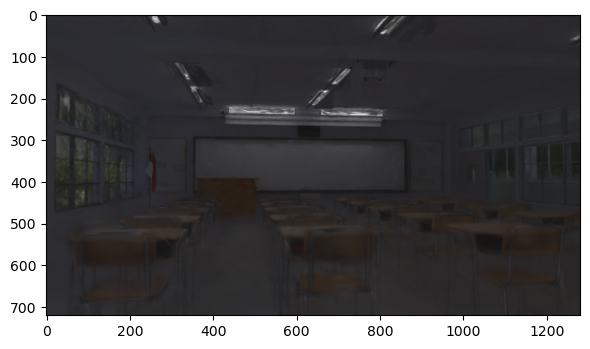

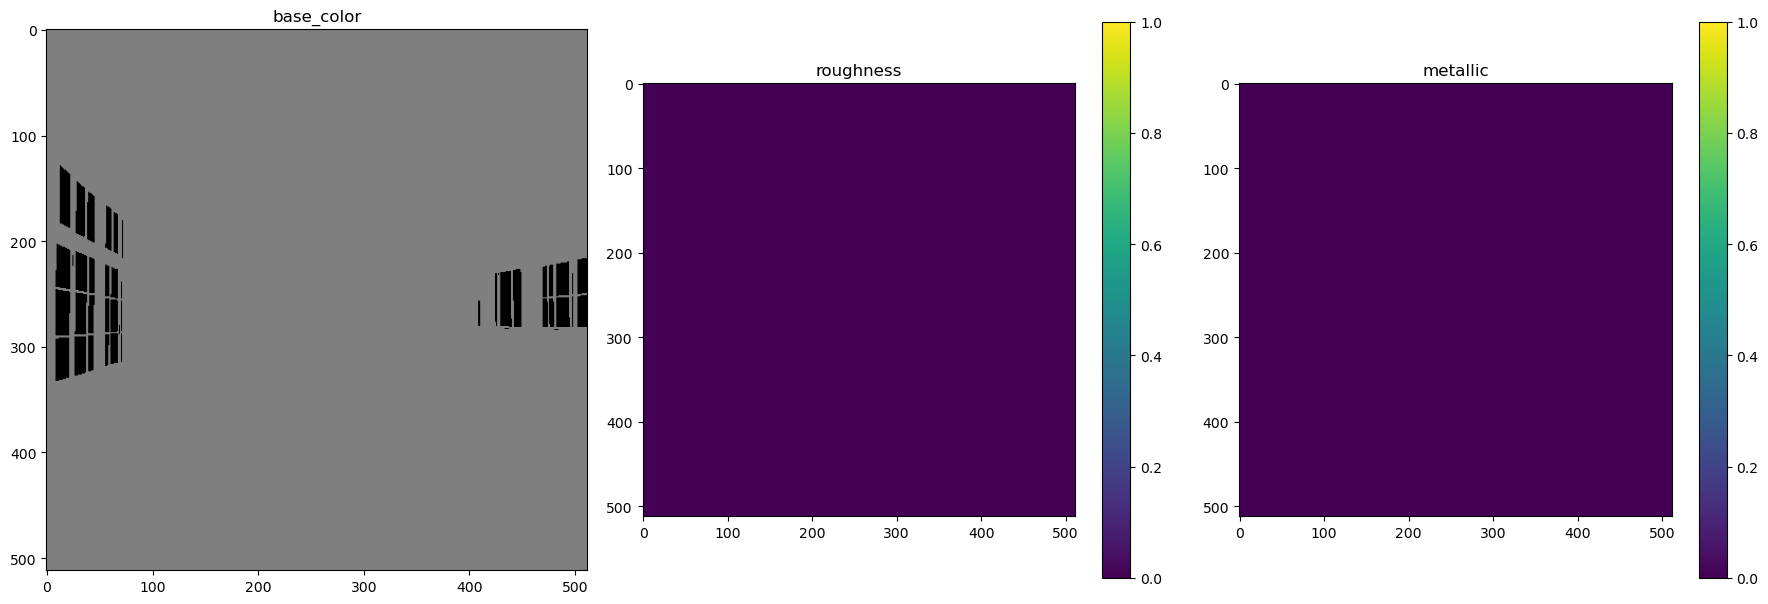

In [9]:
from scripts.radiosity.bsdf_utils import render_attributes, render_attributes_gt, ps_visualize_textures
import matplotlib.pyplot as plt

# ps_visualize_textures(scene)

# Scene render
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(mi.render(scene, integrator=radiance_cache.integrator) ** (1.0 / 2.2)); plt.tight_layout()


# mi.util.write_bitmap("output.exr", mi.render(scene, spp=256))

# BSDF initial values
plt.figure(figsize=(18,6), dpi=100)
out = render_attributes(scene, radiance_cache.phantom_origin, (512, 512), False)
plt.subplot(131); plt.imshow(out[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()

In [10]:
# plt.figure(); plt.imshow(mi.render(scene))

# sensor = mi.load_dict({
#                 'type': 'perspective',
#                 'fov': 60,
#                 'to_world': mi.ScalarTransform4f([
#                     [-0.988479, -0.00428443, 0.151294, -1.69049], 
#                     [9.42177e-010, 0.999599, 0.0283071, 1.27158], 
#                     [-0.151355, 0.027981, -0.988083, 5.88653 - 0.2], 
#                     [0, 0, 0, 1]]),
#             })
# plt.figure(); plt.imshow(mi.render(radiance_cache.gs_scene, sensor=sensor))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9.855919e-06..5.016929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.5930731].


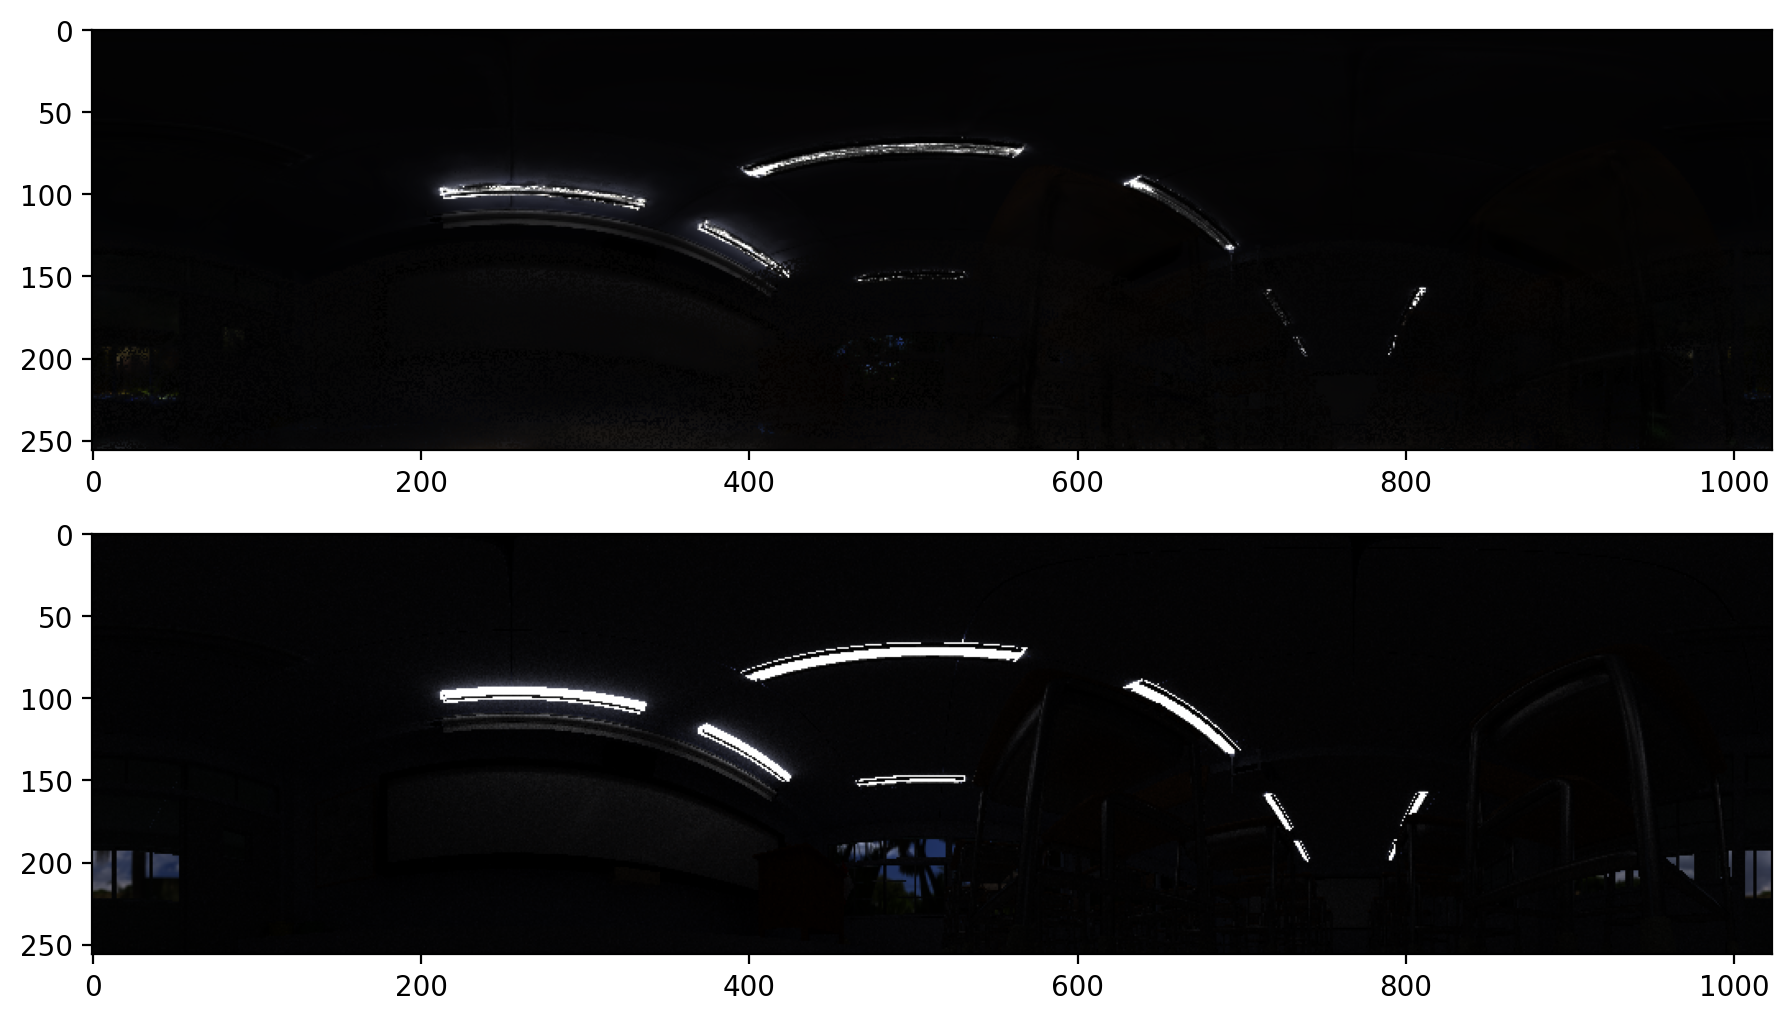

In [11]:
import polyscope as ps

sampler = mi.load_dict({'type': 'independent'})
# seed = 10
seed = 14
si = scene_sampler.sample(1 << 0, sampler, rng_state=seed)[0]
si_wide = dr.gather(type(si), si, dr.zeros(UInt, 256))
wi_rays = radiance_cache.eval_Li_mat(si_wide, sampler)[4]
wo_rays = radiance_cache.eval_Lo(si, sampler)[3]


N = 256
plt.figure(figsize=(13,6), dpi=200)
plt.subplot(211)
img_out, rays = radiance_cache._render_hemisphere(si, sampler, N, offset = 0.2)
img_out, rays = radiance_cache._render_hemisphere_auto_offset(si, sampler, N)
plt.imshow(img_out)
mi.util.write_bitmap("fisheye_gs.exr", mi.Bitmap(img_out))

plt.subplot(212)
img_out_, rays = radiance_cache._render_hemisphere_rt(si, sampler, N, spp = 256)
plt.imshow(img_out_)
mi.util.write_bitmap("fisheye_rt.exr", mi.Bitmap(img_out_))

# ps.init()
# ps_visualize_textures(scene, False)
# wi = ps.register_point_cloud("si", wi_rays.o.numpy().T)
# wi.add_vector_quantity("d", wi_rays.d.numpy().T)
# wo = ps.register_point_cloud("Lo", wo_rays.o.numpy().T)
# wo.add_vector_quantity("d", wo_rays.d.numpy().T)

# # tmp = ps.register_point_cloud("Lo", rays.o.numpy().T)
# # tmp.add_vector_quantity("d", rays.d.numpy().T)

# ps.show()

In [12]:
NUM_GEO_SAMPLES = 1 << 12 # 1 << 14
NUM_WI_DIRECTIONS = 256 << 0

In [13]:
from scripts.radiosity.radiance_cache import compute_loss
from scripts.radiosity.bsdf_utils import render_base_color
from time import time

params = mi.traverse(scene)
keys = [key for key in params.keys() if "vertex_bsdf_base_color" in key]
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

losses = []
for it in range(250):
    if it % 50 == 0:
        render_base_color(scene, (512, 512), True, f"output/itr={it}")

    time1 = time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, num_wo = 1, rng_state = it)
    
    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [1.939512]: Loss = [0.00915997]
Iteration 002 [1.865979]: Loss = [4.1917]
Iteration 003 [1.894574]: Loss = [4.09068]
Iteration 004 [1.898303]: Loss = [24.0183]
Iteration 005 [1.851988]: Loss = [20.3105]
Iteration 006 [1.877635]: Loss = [37.4]
Iteration 007 [1.904442]: Loss = [38.7967]
Iteration 008 [1.890173]: Loss = [86.8543]
Iteration 009 [1.843483]: Loss = [83.7688]
Iteration 010 [1.910536]: Loss = [137.659]
Iteration 011 [1.928344]: Loss = [383.29]
Iteration 012 [1.919662]: Loss = [432.092]
Iteration 013 [1.871348]: Loss = [111.801]
Iteration 014 [1.883111]: Loss = [1544.83]
Iteration 015 [1.898597]: Loss = [182.775]
Iteration 016 [1.847247]: Loss = [215.815]
Iteration 017 [1.841725]: Loss = [312.815]
Iteration 018 [1.911325]: Loss = [1984.29]
Iteration 019 [1.916535]: Loss = [1559.39]
Iteration 020 [1.864857]: Loss = [5218.07]
Iteration 021 [1.864851]: Loss = [1651.42]
Iteration 022 [1.913769]: Loss = [6572.35]
Iteration 023 [1.917901]: Loss = [1156.6]
Iteration 024 

KeyboardInterrupt: 

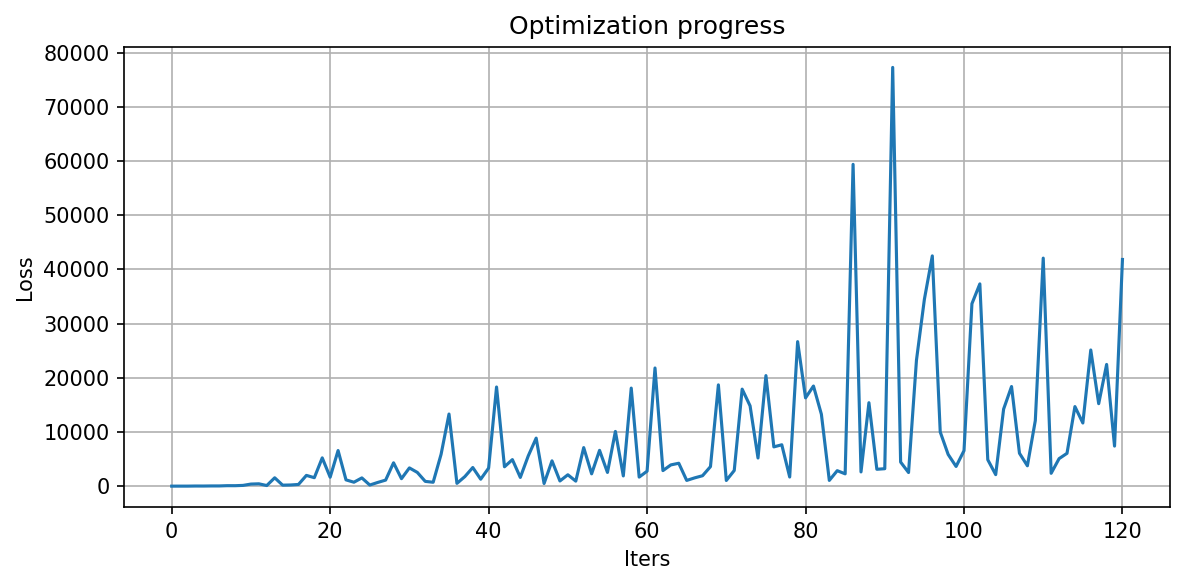

In [14]:
import numpy as np

plt.figure(figsize=(8,4), dpi=150)
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
# plt.savefig("./output/loss.png")

In [15]:
from scripts.radiosity.bsdf_utils import render_attributes, render_attributes_gt

out = render_attributes(scene, (512,512), False, "output/final")
# BSDF final values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()

out_gt = render_attributes_gt(scene, (512,512), False, "output/reference")

# BSDF final values
plt.figure(figsize=(18,6), dpi=100)
plt.subplot(131); plt.imshow(out_gt[:,:,:3]); plt.title("base_color")
plt.subplot(132); plt.imshow(out_gt[:,:,3], vmin=0.0, vmax=1.0); plt.title("roughness"); plt.colorbar()
plt.subplot(133); plt.imshow(out_gt[:,:,4], vmin=0.0, vmax=1.0); plt.title("metallic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out_gt[:,:,5], vmin=0.0, vmax=1.0); plt.title("anisotropic");  plt.colorbar()
# plt.subplot(133); plt.imshow(out_gt[:,:,6], vmin=0.0, vmax=1.0); plt.title("spec_tint");  plt.colorbar()
plt.tight_layout()



TypeError: 'bool' object is not subscriptable